In [ ]:
%load_ext autoreload
%autoreload 2

In [ ]:
%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from pathlib import Path

from tqdm.notebook import tqdm

In [ ]:
import os
os.environ['LOGURU_LEVEL'] = 'INFO'

## Generate Text dataclass objects + metadata

In [ ]:
data_base_dir = Path('/Users/janneke/Documents/Documents – Janneke’s MacBook/data/ocrpostcorrection')
data_base_dir.mkdir(exist_ok=True, parents=True)

In [ ]:
from ocrpostcorrection.icdar_data import generate_data

In [ ]:
in_dir = Path('/Users/janneke/Documents/Documents – Janneke’s MacBook/data/ICDAR2019_POCR_competition_dataset/ICDAR2019_POCR_competition_training_18M_without_Finnish')

In [ ]:
%%time
# Train and val data
data, md = generate_data(in_dir)

11it [00:23,  2.15s/it]

CPU times: user 21 s, sys: 1.13 s, total: 22.2 s
Wall time: 23.7 s


In [ ]:
md

,language,file_name,score,num_tokens,num_input_tokens
0,SL,SL/SL1/29.txt,0.463415,7,7
1,SL,SL/SL1/15.txt,0.773294,155,246
2,SL,SL/SL1/114.txt,0.019256,268,272
3,SL,SL/SL1/100.txt,0.049887,229,238
4,SL,SL/SL1/128.txt,0.015375,282,286
...,...,...,...,...,...
11657,EN,EN/EN1/131.txt,0.076471,147,148
11658,EN,EN/EN1/119.txt,0.718663,173,251
11659,EN,EN/EN1/18.txt,0.053691,237,239
11660,EN,EN/EN1/24.txt,0.374921,248,291


In [ ]:
%%time
# test data
in_dir = Path('/Users/janneke/Documents/Documents – Janneke’s MacBook/data/ICDAR2019_POCR_competition_dataset/ICDAR2019_POCR_competition_evaluation_4M_without_Finnish')
data_test, md_test = generate_data(in_dir)

11it [00:06,  1.73it/s]

CPU times: user 5.65 s, sys: 369 ms, total: 6.02 s
Wall time: 6.36 s


In [ ]:
md_test

,language,file_name,score,num_tokens,num_input_tokens
0,SL,SL/SL1/29.txt,0.992495,2,143
1,SL,SL/SL1/15.txt,0.136364,75,81
2,SL,SL/SL1/14.txt,0.132514,114,121
3,SL,SL/SL1/28.txt,0.028439,269,278
4,SL,SL/SL1/16.txt,0.068158,967,995
...,...,...,...,...,...
3035,EN,EN/EN1/25.txt,0.054126,212,213
3036,EN,EN/EN1/19.txt,0.038427,201,203
3037,EN,EN/EN1/18.txt,0.191576,118,148
3038,EN,EN/EN1/24.txt,0.410843,232,284


## Descriptive statistics

In [ ]:
md.num_tokens.describe()

count    11662.000000
mean       241.053164
std        193.174556
min          0.000000
25%        165.000000
50%        207.000000
75%        237.000000
max       1971.000000
Name: num_tokens, dtype: float64

<AxesSubplot: >

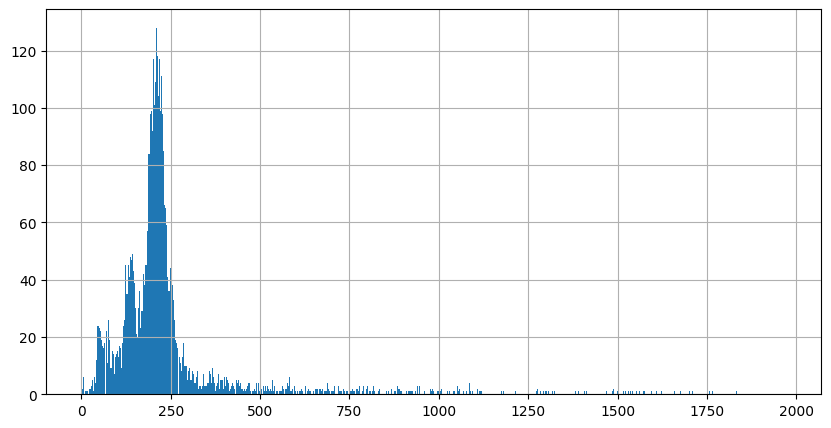

In [ ]:
md.num_tokens.hist(bins=2000, figsize=(10,5))

In [ ]:
md.num_input_tokens.describe()

count    11662.000000
mean       269.510633
std        200.611803
min          0.000000
25%        194.000000
50%        238.000000
75%        267.000000
max       3068.000000
Name: num_input_tokens, dtype: float64

<AxesSubplot: >

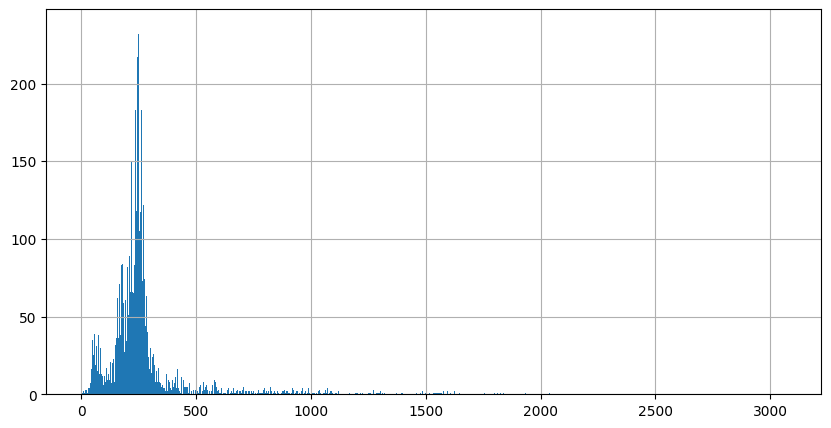

In [ ]:
md.num_input_tokens.hist(bins=2000, figsize=(10,5))

In [ ]:
md.score.describe()

count    11662.000000
mean         0.213661
std          0.126864
min          0.000000
25%          0.125627
50%          0.234694
75%          0.262105
max          1.000000
Name: score, dtype: float64

<AxesSubplot: >

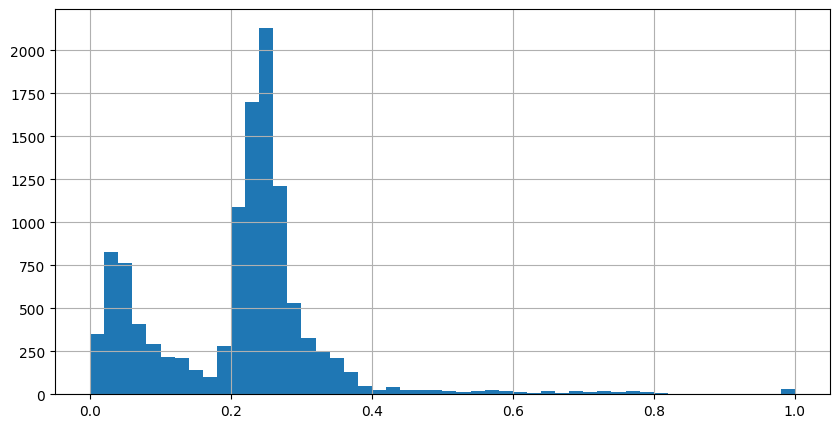

In [ ]:
md.score.hist(bins=50, figsize=(10,5))

In [ ]:
md.query('score <= 0.3').num_tokens.describe()

count    10257.000000
mean       242.240616
std        191.593713
min          2.000000
25%        178.000000
50%        209.000000
75%        236.000000
max       1833.000000
Name: num_tokens, dtype: float64

## Select train and validation texts

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_val, _, _ = train_test_split(md, md['file_name'], test_size=0.1, 
                                        shuffle=True, stratify=md['language'])

In [ ]:
out_dir = data_base_dir/'icdar-dataset-20220427'
out_dir.mkdir(parents=True, exist_ok=True)

In [ ]:
X_train.to_csv(out_dir/'train.csv')
X_val.to_csv(out_dir/'val.csv')

In [ ]:
X_test = md_test

X_test.to_csv(out_dir/'test.csv')

## Load train, val, and test metadata

In [ ]:
in_dir = data_base_dir/'icdar-dataset-20220207'

X_train = pd.read_csv(in_dir/'train.csv', index_col=0)
X_val = pd.read_csv(in_dir/'val.csv', index_col=0)
X_test = pd.read_csv(in_dir/'test.csv', index_col=0)

## Generate sentences

And save as jsonl file

In [ ]:
# Generate 'sentences' for train and val sets

from ocrpostcorrection.icdar_data import generate_sentences

sentence_len = 150

train_data = generate_sentences(X_train, data, size=sentence_len, step=sentence_len)
val_data = generate_sentences(X_val, data, size=sentence_len, step=sentence_len)
test_data = generate_sentences(X_test, data_test, size=sentence_len, step=sentence_len)

10268it [00:36, 321.15it/s]2022-09-06 19:56:24.560 | INFO     | ocrpostcorrection.icdar_data:_process_sequence:268 - Empty sample for text "FR/FR3/1023.txt"
2022-09-06 19:56:24.564 | INFO     | ocrpostcorrection.icdar_data:_process_sequence:269 - ocr_str: 
2022-09-06 19:56:24.565 | INFO     | ocrpostcorrection.icdar_data:_process_sequence:270 - start token: 0
2022-09-06 19:56:24.566 | INFO     | ocrpostcorrection.icdar_data:_process_sequence:268 - Empty sample for text "FR/FR3/1023.txt"
2022-09-06 19:56:24.569 | INFO     | ocrpostcorrection.icdar_data:_process_sequence:269 - ocr_str: 
2022-09-06 19:56:24.577 | INFO     | ocrpostcorrection.icdar_data:_process_sequence:270 - start token: 0
10495it [00:37, 279.46it/s]
220it [00:00, 309.54it/s]2022-09-06 19:56:26.712 | INFO     | ocrpostcorrection.icdar_data:_process_sequence:268 - Empty sample for text "FR/FR3/227.txt"
2022-09-06 19:56:26.714 | INFO     | ocrpostcorrection.icdar_data:_process_sequence:269 - ocr_str: 
2022-09-06 19:56:26.7

In [ ]:
train_data.head()

,key,start_token_id,score,tokens,tags,language
0,FR/FR1/499.txt,0,0.036893,"[Johannes,, Dei, gratia,, Francorum, rex., Not...","[0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, ...",FR
1,FR/FR1/499.txt,150,0.038863,"[subsequta,, ipsaque, Margareta,, cum, familia...","[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",FR
2,FR/FR1/499.txt,300,0.047852,"[tibus, apprhendro, realiter, et, de, facto, p...","[1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, ...",FR
3,FR/FR1/499.txt,407,0.064789,"[favorabiliter, annuentes,, eidem, in, casu, e...","[0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, ...",FR
4,DE/DE6/535.txt,0,0.323495,"[Hap, groie, kummer, dapr, van, effen, an, aec...","[1, 1, 0, 1, 0, 1, 2, 0, 1, 0, 1, 2, 1, 1, 1, ...",DE


In [ ]:
train_data.query('start_token_id > 0')

,key,start_token_id,score,tokens,tags,language
1,FR/FR1/499.txt,150,0.038863,"[subsequta,, ipsaque, Margareta,, cum, familia...","[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",FR
2,FR/FR1/499.txt,300,0.047852,"[tibus, apprhendro, realiter, et, de, facto, p...","[1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, ...",FR
3,FR/FR1/499.txt,407,0.064789,"[favorabiliter, annuentes,, eidem, in, casu, e...","[0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, ...",FR
5,DE/DE6/535.txt,34,0.317552,"[denchen, mach, Dp, ftepn, wurgen, zu, den, zi...","[1, 1, 2, 1, 1, 0, 0, 1, 2, 1, 1, 1, 1, 1, 2, ...",DE
8,DE/DE3/5287.txt,98,0.243063,"[mit, auf—, —, 229, |——, nehmen;, e8, war, ein...","[0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, ...",DE
...,...,...,...,...,...,...
23787,DE/DE6/465.txt,182,0.352450,"[4, anm?, Gegreßnüfß, der, Conig, wnd, propßte...","[1, 1, 2, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 2, ...",DE
23789,DE/DE3/399.txt,19,0.263617,"[Aüftert!, im, Ilnd, ihm, ertöne, Bogelfang, a...","[1, 1, 2, 0, 1, 1, 2, 1, 1, 2, 1, 1, 0, 1, 1, ...",DE
23791,DE/DE2/27.txt,144,0.335597,"[aber, nur, angebrütet, wirb;, ber, ©olbat, Qa...","[0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, ...",DE
23793,ES/ES1/99.txt,14,0.136201,"[con, mano, llena., No, ay, bíe, que’n, mal, n...","[0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 2, 0, ...",ES


In [ ]:
test_data.head()

,key,start_token_id,score,tokens,tags,language
0,SL/SL1/29.txt,0,0.994371,"[Sab, ftojn., 4, Sha, li, ti., S$, le., J, She...","[1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, ...",SL
1,SL/SL1/15.txt,0,0.136364,"[tefts, kraja, zhier, je, -, she.viija, plknia...","[1, 0, 0, 1, 2, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, ...",SL
2,SL/SL1/14.txt,0,0.132333,"[39*, Prekajeno, kravje, vime., ,, 40., Divja,...","[1, 1, 0, 1, 2, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, ...",SL
3,SL/SL1/28.txt,0,0.026829,"[155, Kedar, Jezus, na, verh, gore, perjezdi,,...","[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, ...",SL
4,SL/SL1/28.txt,128,0.031250,"[Ljudstvo, pravi:, „Jezus, prerok!, 44, Jezus,...","[0, 0, 0, 1, 2, 0, 0, 0, 0, 0, 0, 0, 0, 1, 2, ...",SL


In [ ]:
out_dir = data_base_dir/'icdar-dataset-seq_len-150'
out_dir.mkdir(exist_ok=True, parents=True)


train_data.to_json(out_dir/'icdar_train.jsonl', orient='records', lines=True)
val_data.to_json(out_dir/'icdar_val.jsonl', orient='records', lines=True)
test_data.to_json(out_dir/'icdar_test.jsonl', orient='records', lines=True)

## Load dataset from json files

And create hf dataset.

In [ ]:
from datasets import load_dataset

out_dir = data_base_dir/'icdar-dataset-seq_len-150'

data_files = {'train': str(out_dir/'icdar_train.jsonl'),
              'val': str(out_dir/'icdar_val.jsonl'),
              'test': str(out_dir/'icdar_test.jsonl')}

icdar_dataset = load_dataset("json", data_files=data_files)

Using custom data configuration default-07f5c779917806dd


Extracting data files:   0%|          | 0/3 [00:00<?, ?it/s]

0 tables [00:00, ? tables/s]

0 tables [00:00, ? tables/s]

0 tables [00:00, ? tables/s]

Dataset json downloaded and prepared to /Users/janneke/.cache/huggingface/datasets/json/default-07f5c779917806dd/0.0.0/e6070c77f18f01a5ad4551a8b7edfba20b8438b7cad4d94e6ad9378022ce4aab. Subsequent calls will reuse this data.


  0%|          | 0/3 [00:00<?, ?it/s]

In [ ]:
# Add class labels to dataset
from datasets import Sequence, ClassLabel

icdar_dataset = icdar_dataset.cast_column('tags', Sequence(feature=ClassLabel(num_classes=3, names=['O', 'OCR-Mistake-B', 'OCR-Mistake-I']), length=-1))

Casting the dataset:   0%|          | 0/3 [00:00<?, ?ba/s]

Casting the dataset:   0%|          | 0/1 [00:00<?, ?ba/s]

Casting the dataset:   0%|          | 0/1 [00:00<?, ?ba/s]

In [ ]:
icdar_dataset

DatasetDict({
    train: Dataset({
        features: ['key', 'start_token_id', 'score', 'tokens', 'tags', 'language'],
        num_rows: 23796
    })
    val: Dataset({
        features: ['key', 'start_token_id', 'score', 'tokens', 'tags', 'language'],
        num_rows: 2651
    })
    test: Dataset({
        features: ['key', 'start_token_id', 'score', 'tokens', 'tags', 'language'],
        num_rows: 7010
    })
})

In [ ]:
train_data.score.describe()

NameError: name 'train_data' is not defined

<AxesSubplot:>

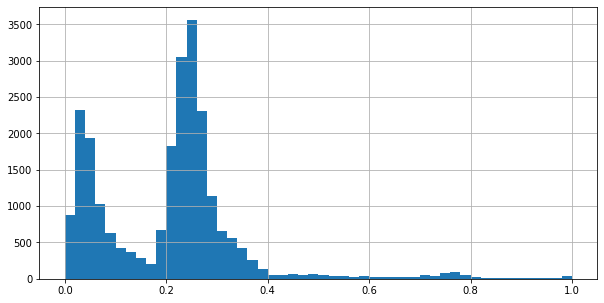

In [ ]:
train_data.score.hist(bins=50, figsize=(10,5))

In [ ]:
val_data.score.describe()

count    1626.000000
mean        0.193956
std         0.162305
min         0.000000
25%         0.049308
50%         0.214722
75%         0.259636
max         1.000000
Name: score, dtype: float64

<AxesSubplot:>

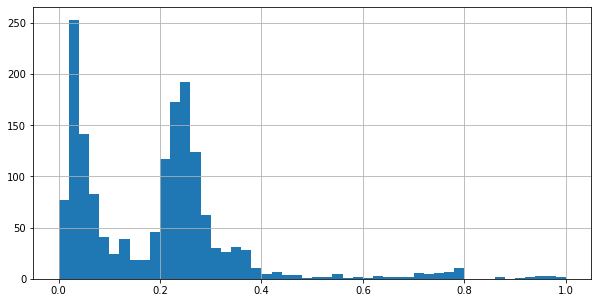

In [ ]:
val_data.score.hist(bins=50, figsize=(10,5))

In [ ]:
icdar_dataset.save_to_disk(data_base_dir/'icdar-seq_len-150')

## Load icdar dataset

In [ ]:
from datasets import load_from_disk

icdar_dataset = load_from_disk(data_base_dir/'icdar-seq_len-150')

In [ ]:
icdar_dataset

DatasetDict({
    train: Dataset({
        features: ['key', 'start_token_id', 'score', 'tokens', 'tags', 'language'],
        num_rows: 23796
    })
    val: Dataset({
        features: ['key', 'start_token_id', 'score', 'tokens', 'tags', 'language'],
        num_rows: 2651
    })
    test: Dataset({
        features: ['key', 'start_token_id', 'score', 'tokens', 'tags', 'language'],
        num_rows: 7010
    })
})

## Create 'perfect' icdar output

In [ ]:
from collections import defaultdict
from ocrpostcorrection.token_classification import extract_icdar_output

result = {}
for key, text_obj in data_test.items():
    result[key] = [t.label for t in text_obj.input_tokens]

output = {}
for key, labels in result.items():
    label_str = ''.join([str(label) for label in labels])
    output[key] = extract_icdar_output(label_str, data_test[key].input_tokens)

In [ ]:
import json

out_dir = data_base_dir/'results'/'icdar-data-20220906-sent_len-150'
out_dir.mkdir(parents=True, exist_ok=True)

out_json = out_dir/'results_task1_perfect.json'

with open(out_json, 'w') as f:
    json.dump(output, f)

In [ ]:
[t for t in data_test['FR/FR3/284.txt'].input_tokens if t.label != 0]

[InputToken(ocr="d'articles", gs='d’articles', start=244, len_ocr=10, label=1),
 InputToken(ocr='19:16:15', gs='19:16:15', start=324, len_ocr=8, label=1),
 InputToken(ocr='mil', gs='', start=333, len_ocr=3, label=2)]

In [ ]:
output['FR/FR3/284.txt']

{'244:1': {}, '324:2': {}}

In [ ]:
out_csv = out_dir/'results_task1_perfect.csv'

In [ ]:
!python ../evalTool_ICDAR2017.py ../../../data/ICDAR2019_POCR_competition_dataset/ICDAR2019_POCR_competition_evaluation_4M_without_Finnish {out_json} {out_csv}

Using:
datasetDirPath: ../../../data/ICDAR2019_POCR_competition_dataset/ICDAR2019_POCR_competition_evaluation_4M_without_Finnish 
pathInputJsonErrorsCorrections: ../../../data/ocrpostcorrection/results/icdar-data-20220906-sent_len-150/results_task1_perfect.json 
pathOutputCsv: ../../../data/ocrpostcorrection/results/icdar-data-20220906-sent_len-150/results_task1_perfect.csv

File	NbTokens	NbErroneousTokens	NbSymbolsConsidered	T1_Precision	T1_Recall	T1_Fmesure	T2_AvgLVDistOriginal	T2_AvgLVDistCorrected
SL/SL1/29.txt	2	2	532	1.00	1.00	1.00	0.99	0.99
SL/SL1/15.txt	83	28	404	1.00	1.00	1.00	0.15	0.15
SL/SL1/14.txt	115	50	624	1.00	1.00	1.00	0.16	0.16
SL/SL1/28.txt	273	21	1270	1.00	1.00	1.00	0.03	0.03
SL/SL1/16.txt	1004	182	4838	1.00	1.00	1.00	0.08	0.08
SL/SL1/17.txt	1009	333	4929	1.00	1.00	1.00	0.19	0.19
SL/SL1/13.txt	139	49	715	1.00	1.00	1.00	0.09	0.09
SL/SL1/12.txt	333	30	1491	1.00	1.00	1.00	0.03	0.03
SL/SL1/10.txt	314	36	1278	1.00	1.00	1.00	0.05	0.05
SL/SL1/38.txt	405	33	1995	1.00	1.00	1.

In [ ]:
data = pd.read_csv(out_csv, sep=';')
data['language'] = data.File.apply(lambda x: x[:2])
data['subset'] = data.File.apply(lambda x: x.split('/')[1])
data

,File,NbTokens,NbErroneousTokens,NbSymbolsConsidered,T1_Precision,T1_Recall,T1_Fmesure,T2_AvgLVDistOriginal,T2_AvgLVDistCorrected,language,subset
0,SL/SL1/29.txt,2,2,532,1.0,1.0,1.0,0.99,0.99,SL,SL1
1,SL/SL1/15.txt,83,28,404,1.0,1.0,1.0,0.15,0.15,SL,SL1
2,SL/SL1/14.txt,115,50,624,1.0,1.0,1.0,0.16,0.16,SL,SL1
3,SL/SL1/28.txt,273,21,1270,1.0,1.0,1.0,0.03,0.03,SL,SL1
4,SL/SL1/16.txt,1004,182,4838,1.0,1.0,1.0,0.08,0.08,SL,SL1
...,...,...,...,...,...,...,...,...,...,...,...
3035,EN/EN1/25.txt,232,26,929,1.0,1.0,1.0,0.06,0.06,EN,EN1
3036,EN/EN1/19.txt,208,20,932,1.0,1.0,1.0,0.05,0.05,EN,EN1
3037,EN/EN1/18.txt,124,40,635,1.0,1.0,1.0,0.22,0.22,EN,EN1
3038,EN/EN1/24.txt,297,76,1601,1.0,1.0,1.0,0.39,0.39,EN,EN1


In [ ]:
print(data.groupby('language').mean()[['T1_Precision', 'T1_Recall', 'T1_Fmesure']].to_markdown())

| language   |   T1_Precision |   T1_Recall |   T1_Fmesure |
|:-----------|---------------:|------------:|-------------:|
| BG         |         1      |    1        |     1        |
| CZ         |         1      |    1        |     1        |
| DE         |         1      |    0.990685 |     0.99678  |
| EN         |         1      |    1        |     1        |
| ES         |         1      |    1        |     1        |
| FI         |         1      |    0.931875 |     0.962    |
| FR         |         1      |    0.920084 |     0.954595 |
| NL         |         1      |    1        |     1        |
| PL         |         0.9998 |    1        |     0.9998   |
| SL         |         1      |    0.999583 |     0.999792 |


In [ ]:
data[data.T1_Precision < 1]

,File,NbTokens,NbErroneousTokens,NbSymbolsConsidered,T1_Precision,T1_Recall,T1_Fmesure,T2_AvgLVDistOriginal,T2_AvgLVDistCorrected,language,subset
69,PL/PL1/6.txt,312,136,1659,0.99,1.0,0.99,0.14,0.14,PL,PL1


In [ ]:
data[data.T1_Recall < 1]

,File,NbTokens,NbErroneousTokens,NbSymbolsConsidered,T1_Precision,T1_Recall,T1_Fmesure,T2_AvgLVDistOriginal,T2_AvgLVDistCorrected,language,subset
26,SL/SL1/0.txt,283,29,1197,1.0,0.98,0.99,0.05,0.05,SL,SL1
243,DE/DE6/15.txt,177,151,975,1.0,0.99,1.00,0.40,0.40,DE,DE6
244,DE/DE6/114.txt,173,124,856,1.0,0.99,1.00,0.35,0.35,DE,DE6
245,DE/DE6/100.txt,328,277,1687,1.0,0.99,1.00,0.42,0.42,DE,DE6
246,DE/DE6/128.txt,192,147,910,1.0,0.99,1.00,0.35,0.35,DE,DE6
...,...,...,...,...,...,...,...,...,...,...,...
2887,FR/FR3/30.txt,52,12,271,1.0,0.89,0.94,0.09,0.09,FR,FR3
2888,FR/FR3/253.txt,176,12,833,1.0,0.86,0.92,0.02,0.02,FR,FR3
2889,FR/FR3/247.txt,96,19,462,1.0,0.91,0.95,0.09,0.09,FR,FR3
2890,FR/FR3/290.txt,64,18,330,1.0,0.90,0.95,0.08,0.08,FR,FR3


In [ ]:
data[data.T1_Recall < 1].groupby('language').mean()[['T1_Precision', 'T1_Recall', 'T1_Fmesure']]

,T1_Precision,T1_Recall,T1_Fmesure
language,,,
DE,1.0,0.988682,0.996087
FI,1.0,0.904386,0.946667
FR,1.0,0.865597,0.923636
SL,1.0,0.980000,0.990000
